In [1]:
import astropy.io.fits
import astropy.io.fits
import numpy as np
import numpy.ma as ma
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d
import causticpy
import matplotlib.pyplot as plt
from numpy import log as ln
import astropy.io.fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import scipy.stats as stats
from astLib import astCoords as aco
from astLib import astStats as ast
from astLib import astCalc as aca
from astropy.stats import sigma_clip 
from colossus.halo import profile_nfw
import sherpa.astro.ui as ui
import uncertainties
from scipy.optimize import least_squares
from uncertainties import ufloat
from uncertainties import ufloat, umath, unumpy
try:
    from uncertainties import Variable
except ImportError:
    from uncertainties.core import Variable
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology
c=const.c.to("km/s").value
%matplotlib inline

# Define the paths to the data files
path_2_data = [
    'massive_cluster2.fit',  # ACO 2219  9.8 keV ,38.300  ,Lambda  72 + 2.6
    'kidstable.fit',         # ACO 1835  7.65   ,39.600      ,114.096 ,4.96
    'massive_cluster7.fit',  # # Abel 2218  6.70  ,8.460  ,  58 ,2.36
    'massive_cluster8.fit',  # MACS J0717.5+3745  10.50 ,46.900 ,77.57 ,3.94
    'massive_cluster13.fit', # ACO 1763   6.9  ,  9.330    71,65, 2.85
    'massive_cluster15.fit', # ACO 1758   7.95  ,21.100 , 41.90, 2.94
    'massive_cluster16.fit', # Abel 665   8.30  ,13.500  ,71.5  ,2.57
    
]

# Loop over the clusters
for i, path in enumerate(path_2_data):
    print('Opening', path)
    my_file = astropy.io.fits.open(path)
    data = my_file[1].data

    # cluster analysis
    ra = data.field('ra')
    dec = data.field('dec')
    zspec = data.field('zspec')

    # Neglecting nans from the data set
    z0 = data.field('zspec')
    mask0 = np.where(z0 > 0)
    z_gal = zspec[mask0]

    # After the removal of nans
    ra_gal = ra[mask0]
    dec_gal = dec[mask0]

    # Sigma clipping to remove the interlopers
    clipped_redshift = sigma_clip(z_gal, sigma=2.5, maxiters=10000)

    zz = []
    zk = []
    for x in range(len(clipped_redshift)):
        if not ma.is_masked(clipped_redshift[x]):
            zz.append(clipped_redshift[x])
        else:
            zk.append(clipped_redshift[x])

    z_halo = np.array(zz)
    mask1 = np.where(z_halo)
    z_halo_max, z_halo_min = z_halo.max(), z_halo.min()

    # cluster's coordinates
    ra_masked = ra_gal[mask1]
    dec_masked = dec_gal[mask1]
    ra_cl = np.mean(ra_masked)
    dec_cl = np.mean(dec_masked)
    z_cl = np.mean(z_halo)

    # caustic analysis
    cluster_data = np.vstack((ra_masked, dec_masked, z_halo)).T
    caustic = causticpy.Caustic()
    caustic.run_caustic(cluster_data)

    caustic.run_caustic(cluster_data, clus_ra=caustic.clus_ra, clus_dec=caustic.clus_dec, clus_z=caustic.clus_z)

    h0 = 67.77
    class MassCalc:
        def __init__(self, ri, A, vdisp, clus_z, r200=None, conc1=None, beta=0.25, fbr=None, H0=h0):
            "Calculate the mass profile"
            G = 6.67E-11
            solmass = 1.98892e30
            self.crit = 2.7745946e11 * (H0 / 100.0) ** 2.0 * (0.25 * (1 + clus_z) ** 3.0 + 0.75)
            r2 = ri[ri >= 0]
            A2 = A[ri >= 0]
            kmMpc = 3.08568025e19
            sumtot = np.zeros(A2.size)

            if conc1 is None:
                self.conc = 5.0 + np.random.normal(0, 2.0)
                if self.conc <= 0:
                    self.conc = 5.0
            else:
                self.conc = conc1
            beta = 0.5 * (ri / (ri + r200 / self.conc))
            self.g_b = (3 - 2.0 * beta) / (1 - beta)
            if fbr is None:
                self.f_beta = 0.5 * ((r2 / r200 * self.conc) ** 2) / (
                        (1 + ((r2 / r200 * self.conc))) ** 2 * np.log(1 + ((r2 / r200 * self.conc)))) * self.g_b
                self.f_beta[0] = 0
                for i in range(A2.size - 1):
                    i += 1
                    sumtot[i] = np.trapz(self.f_beta[1:i + 1] * (A2[1:i + 1] * 1000) ** 2, (r2[1:i + 1]) * kmMpc * 1000)
            else:
                if isinstance(fbr, float) or isinstance(fbr, int) or isinstance(fbr, np.float64):
                    self.f_beta = np.zeros(A2.size) + fbr * 1.0
                else:
                    self.f_beta = fbr
                self.f_beta[0] = 0
                for i in range(A2.size - 1):
                    i += 1
                    sumtot[i] = np.trapz(self.f_beta[1:i + 1] * (A2[1:i + 1] * 1000) ** 2, (r2[1:i + 1]) * kmMpc * 1000)

            self.massprofile = sumtot / (G * solmass)

            self.avg_density = self.massprofile / (4.0 / 3.0 * np.pi * (ri[:self.f_beta.size]) ** 3.0)
            try:
                finterp = interp1d(self.avg_density[::-1], ri[:self.f_beta.size][::-1])
                self.r200_est = finterp(200 * self.crit)
                self.r500_est = finterp(500 * self.crit)
            except IndexError:
                self.r200_est = 0.0
                self.r500_est = 0.0
            finterp = interp1d(ri[:self.f_beta.size], self.massprofile)
            self.M200_est = finterp(self.r200_est)
            self.M500_est = finterp(self.r500_est)
            self.M200 = self.massprofile[np.where(ri[:self.f_beta.size] <= r200)[0][-1]]
    
        
   
    # Calculate mass using MassCalc
    m = MassCalc(
        ri=caustic.x_range,
        A=caustic.caustic_profile,
        vdisp=caustic.vdisp_gal,
        clus_z=caustic.clus_z,
        r200=caustic.r200,
        conc1=5,
        beta=0.33,
        fbr=None,
        H0=67.77,
    )
    print(
        m.M500_est/1e15, caustic.clus_z, ra_cl, dec_cl 
    # Print the results
    #print(
    #    m.M200_est, m.M200 
    )
    

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'
Opening massive_cluster2.fit
DATA SET SIZE 193
Pre_r200= 1.5596219770123363
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1105.2117489028467
Combined Vdisp= 1105.2117489028467
Calculating initial surface
complete
DATA SET SIZE 193
Pre_r200= 1.5596219770123363
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1105.2117489028467
Combined Vdisp= 1105.2117489028467
Calculating initial surface
complete
r200 estimate:  1.5867593271761564
M200 estimate:  1123128615264413.5
1.0733504409358903 0.22567697122846683 250.09398041722073 46.70991551616914
Opening kidstable.fit
DATA SET SIZE 105
Pre_r200= 1.9032855965190718
Calculating Density w/Mirrored Data
Vdisp from galaxies= 1417.792757041211
Combined Vdisp= 1417.792757041211
Calculating initial surface
complete
DATA SET SIZE 105
Pre_r200= 1.9032855965190718
Calculating Density w/Mirrored Data
Vdisp from galaxies= 141

In [172]:
# m500 of the clusters
mm=np.array([1.0687801187382955 ,1.8912582518913406 ,1.3137489159528748,1.6943235694538645,1.7822254345415798,1.53607715026715,1.4758585057048683  ])

In [173]:
# redshifts of the clusters
red=np.array([ 0.22579844657218817,0.2525568867013568, 0.17362493143914498, 0.54474090837469, 0.23189751784268178,0.27671193723325377 ,0.18275992755872617])

In [174]:
M_500=mm*1e15
z=red
z

array([0.22579845, 0.25255689, 0.17362493, 0.54474091, 0.23189752,
       0.27671194, 0.18275993])

In [175]:
def E(z):
    """
    Evolution factor E(z) at a given redshift.
    """
    try:
        return (Om0 * (1+z)**3 + Omega_k * (1+z)**2 + Ode0) ** 0.5
    except AttributeError:
        from uncertainties import unumpy
        return unumpy.sqrt(Om0 * (1+z)**3 + Omega_k * (1+z)**2 + Ode0)

In [176]:
# from the literature
Tobs =np.array([9.8,7.65,6.70,10.50,6.9,7.95,8.30])

#Literature
Lx= np.array([ 38.300, 39.600,8.460 ,46.900 ,9.330 ,21.100,13.500])*1e44


# Temprature Mass Redshift scaling relation

In [187]:
# Using Arnaud 2005
def T_M_relation(M, z, A=3.79e14, B=1.64):
    """
    Computes the temperature of a galaxy cluster given its mass and redshift,
    using the M-T scaling relation by Arnaud et al. (2005).
    
    Args:
    - M (float): mass of the cluster in solar masses
    - z (float): redshift of the cluster
    - A (float): scaling factor (default: 3.79e14 Msol)
    - B (float): scaling index (default: 1.64)
    
    Returns:
    - T (float): temperature of the cluster in keV
    """
    E_z = np.sqrt(0.3*(1+z)**3 + 0.7)
    T = 5*(M/(A*E_z**0.5))**(1/B)
    return T
tt=T_M_relation(mm*1e15,red)
tt

array([ 9.09083815, 12.81779214, 10.39741624, 11.38679974, 12.40447525,
       11.24521678, 11.14559538])

In [188]:
Tobs =np.array([9.8,7.65,6.70,10.50,6.9,7.95,8.30])


Text(0.5, 0, 'Mass of the cluster')

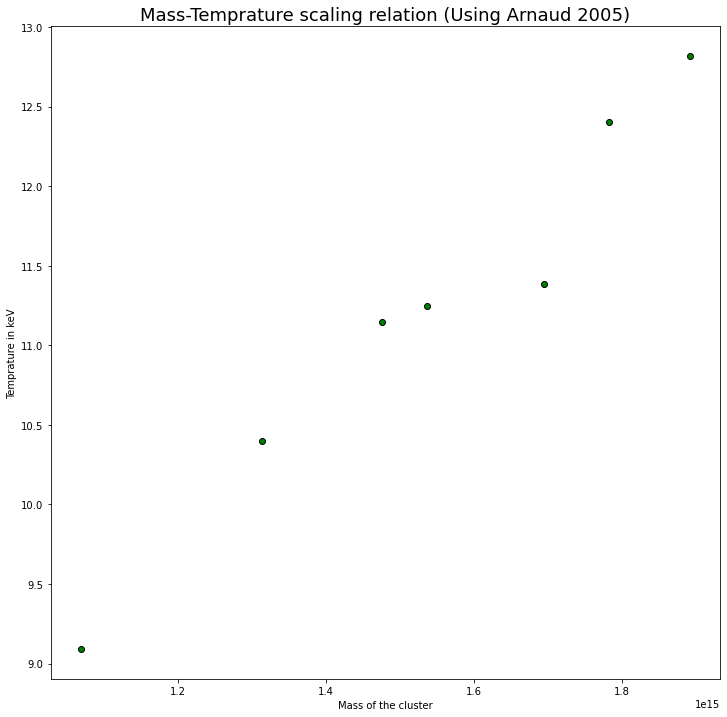

In [189]:
plt.figure(figsize=(12,12))
plt.title('Mass-Temprature scaling relation (Using Arnaud 2005)',fontsize=18)
plt.plot(mm*1e15,tt, color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='green', markersize=12)
plt.ylabel('Temprature in keV')
plt.xlabel('Mass of the cluster')

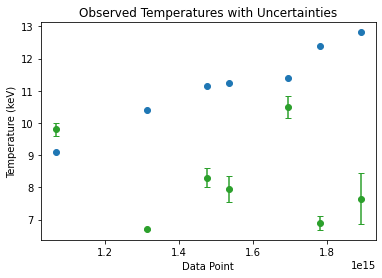

In [190]:
plt.plot(mm*1e15,tt,'o')
plt.plot(mm*1e15,Tobs,'.')

uncertainties = np.array([0.2, 0.8,0.02,.34,.21,0.4,0.3])  # Uncertainties associated with the temperatures
plt.errorbar(mm*1e15, Tobs, yerr=uncertainties, fmt='o', capsize=3)
plt.xlabel("Data Point")
plt.ylabel("Temperature (keV)")
plt.title("Observed Temperatures with Uncertainties")

plt.show()


# # same relation using the Bulbul.el.19 paper

In [191]:
Om0=0.307115
Ode0=0.692885
Omega_k=0
z_piv= 0.269727
E(z_piv)
z_piv= 0.269727
M_piv= 1.53e15

In [192]:
E_z = np.sqrt(0.3*(1+z)**3 + 0.7)
E_z_piv = np.sqrt(0.3*(1+z_piv)**3 + 0.7)

<ErrorbarContainer object of 3 artists>

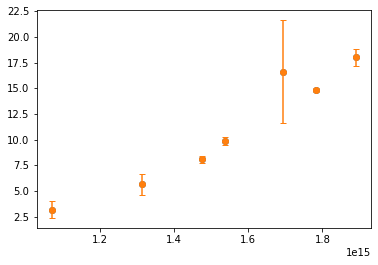

In [193]:
TT=bulbul19(Obs,8.41, 2.99, 2.36)
uncertainties = np.array([0.8, 0.8,1.0,5,.21,0.4,0.3]) 
plt.plot(M_500, TT,'o')
plt.errorbar(M_500, TT, yerr=uncertainties, fmt='o', capsize=3)

 # Uncertainties associated with the temperatures


In [194]:
Ax= 6.41
Bx= 0.80
cx= -0.36
Obs =M_500,z
E(z)
def bulbul19(Obs,Ax,Bx,cx):
    M_500, z=Obs
    z_piv= 0.269727
    M_piv= 1.53e15
    return (Ax * (M_500 / M_piv)**Bx )*(E_z / E_z_piv)**(2/3)*(1 + z / (1 + z_piv)**cx)

p0 = [8.41, 0.80, -0.36]  # Initial guess for parameters

# Perform the fitting process
popt,pcov=curve_fit(bulbul19, (M_500,z),Tobs, p0=p0)

#  get the best-fit parameters
Ax_fit, Bx_fit, cx_fit = popt
# Evaluate the fit
T_x_fit_bulbul19 = bulbul19(Obs, Ax_fit, Bx_fit, cx_fit)

Ax_fit, Bx_fit, cx_fit

(6.3137527575689925, -0.5282806886762306, -0.3333436868919365)

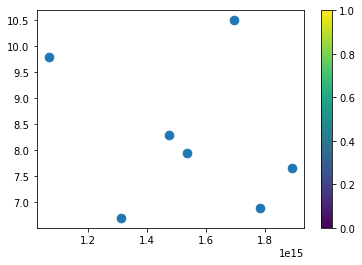

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt


points = plt.scatter(M_500, Tobs, s=75, cmap="BuGn")
plt.colorbar(points)



In [196]:
mas

array([3.51119173e+14, 4.11666431e+14, 2.31012970e+14, 1.31825674e+14,
       1.25366591e+14, 4.62865216e+14, 3.72313763e+14, 2.10686333e+14])

In [197]:
temp

array([15.24118968,  9.32848937,  7.03347278,  4.59477396,  4.30489204,
        3.81181729,  2.80007595,  1.88569608])

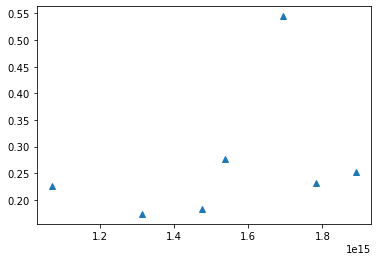

In [199]:
plt.plot(M_500,z,'^')

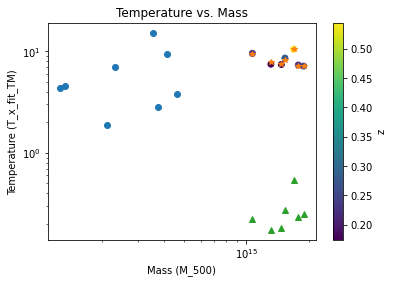

In [200]:
import matplotlib.pyplot as plt

# Assuming you have your temperature and mass data stored in the variables T_x_fit_TM and M_500
# Also assuming you have the variable 'z' representing the other variable

plt.scatter(M_500, T_x_fit_TM, c=z)  # Use scatter plot instead of plot for color mapping
plt.plot(mas,temp,'o')
plt.plot(M_500,T_x_fit_bulbul19,'*' )
#plt.plot(M_500, Tobs,'o')
plt.plot(M_500,z,'^')


plt.xlabel('Mass (M_500)')
plt.ylabel('Temperature (T_x_fit_TM)')
plt.title('Temperature vs. Mass')

# Add color bar
cbar = plt.colorbar()
cbar.set_label('z')  # Set label for the color bar

#plt.grid(True)
plt.loglog()
#plt.xlim(1e13,1.5e15)
#plt.ylim(1e0,18)

plt.show()


In [202]:
# By using least square
def objective(params, M500, z, Tx_observed):
    Ax, Bx, cx= params
    Tx_predicted = (Ax * (M500 / M_piv)**Bx) * ((E_z / E_z_piv)**(2/3)) * (1 + z / (1 + z_piv)**cx)
    residuals = Tx_observed - Tx_predicted
    return residuals

# Generate some example data
M_500   # example values of M500
z  # example values of z
Tobs # example observed temperatures

# Set initial guesses for the parameter values
initial_params = [1.0, 0.5, 0.2]  # example initial parameter values

# Perform the nonlinear least squares fitting
result = least_squares(objective, initial_params, args=(M_500, z, Tobs))

# Retrieve the optimized parameter values
optimized_params = result.x
print("Optimized parameter values:", optimized_params)


Optimized parameter values: [ 6.31374896 -0.52828193 -0.33335384]


In [203]:
    Tx_predicted = (Ax * (M_500 / M_piv)**Bx) * ((E_z / E_z_piv)**(2/3)) * (1 + z / (1 + z_piv)**cx)


In [204]:
# using Maximum liklihood technique

import numpy as np
from scipy.optimize import minimize

# Define the log-likelihood function
def log_likelihood(params, M500, z, Tx_observed):
    Ax, Bx, cx= params
    Tx_predicted = (Ax * (M_500 / M_piv)**Bx) * ((E_z / E_z_piv)**(2/3)) * (1 + z / (1 + z_piv)**cx)
    residuals = Tobs - Tx_predicted
    sigma = np.std(residuals)  # Estimate the standard deviation of the residuals
    log_likelihood = -0.5 * np.sum((residuals / sigma)**2 + np.log(2 * np.pi * sigma**2))
    return log_likelihood


# Set initial guesses for the parameter values
initial_params = [1.0, 0.5, 0.2]  # example initial parameter values

# Define the negative log-likelihood function (to be minimized)
def negative_log_likelihood(params):
    return -log_likelihood(params, M_500, z, Tobs)

# Perform maximum likelihood estimation
result = minimize(negative_log_likelihood, initial_params)

# Retrieve the optimized parameter values
optimized_params = result.x
print("Optimized parameter values:", optimized_params)


Optimized parameter values: [ 6.31374986 -0.52828181 -0.3333513 ]


# $T_x = \exp\left(\ln A_{\text{Tx}} + \left([ B_{\text{Tx}} + c_{\text{Tx}} \cdot (\frac{1+z}{1+z_{\text{piv}})}] \right) \cdot \ln \frac{M_{500}}{M_{\text{piv}}} + B \cdot \ln \frac{E_z}{E_{z_{\text{piv}}}} + y_{\text{Tx}} \cdot \ln (\frac{1+z}{1+z_{\text{piv}}}) \right)$

In [205]:
Ax= 6.41
Bx= 0.80
cx= -0.36
Obs =M_500,z

def bulbul19(Obs,Ax,Bx,cx):
    M_500, z=Obs
    z_piv= 0.269727
    M_piv= 1.53e15
    return (Ax * (M_500 / M_piv)**Bx )*((E_z / E_z_piv)**(2/3))*(1 + z / (1 + z_piv)**cx)

p0 = [8.41, 0.80, -0.36]  # Initial guess for parameters

# Perform the fitting process
popt,pcov=curve_fit(bulbul19, (M_500,z),Tobs, p0=p0)

#  get the best-fit parameters
Ax_fit, Bx_fit, cx_fit = popt
# Evaluate the fit
T_x_fit_bulbul19 = bulbul19(Obs, Ax_fit, Bx_fit, cx_fit)

Ax_fit, Bx_fit, cx_fit

(6.3137527575689925, -0.5282806886762306, -0.3333436868919365)

In [206]:
# parameters from the paper
#A_Tx = 4.27
#B_Tx = 0.65
#c_Tx = -0.02
#y_Tx = -1.03
#M_piv = 1.5374e15
#z_piv = 0.269727222246006
z=red
E_z = np.sqrt(0.3*(1+z)**3 + 0.7)
E_z_piv = np.sqrt(0.3*(1+z_piv)**3 + 0.7)


def TM(Obs, A_Tx,B_Tx, c_Tx,  y_Tx):
    """paper : https://arxiv.org/abs/2107.05652 
    """
    return np.exp((ln(A_Tx) + (B_Tx + c_Tx * ln(1+z/1+z_piv)) * ln(M_500/M_piv) + 2/3 * ln(E_z/E_z_piv) + y_Tx * ln(1+z/1+z_piv)) )   

p0 = [3.41, 0.65, -0.02,-1.03]  # Initial guess for parameters

# Perform the fitting process
popt,pcov=curve_fit(TM, (M_500,z),Tobs, p0=p0) 

#  get the best-fit parameters
Ax_fit, Bx_fit, cx_fit,yx_fit = popt
# Evaluate the fit
T_x_fit_TM = TM(Obs, Ax_fit, Bx_fit, cx_fit,yx_fit)

Ax_fit, Bx_fit, cx_fit,yx_fit


(3.594607693157528, 2.9675627097114408, -8.679680991220142, 1.9894373931619087)

In [207]:
curve_fit(TM, (M_500,z),Tobs, p0=p0)

(array([ 3.59460769,  2.96756271, -8.67968099,  1.98943739]),
 array([[  2.86655759,  -7.32097879,  18.38485433,  -2.0042168 ],
        [ -7.32097879,  25.84069114, -63.99064406,   5.38221199],
        [ 18.38485433, -63.99064406, 158.79050786, -13.48425508],
        [ -2.0042168 ,   5.38221199, -13.48425508,   1.41855154]]))

In [208]:
Tchiu= TM(Obs,3.594607693157528, 2.9675627097114408, -8.679680991220142, 1.9894373931619087)
Tchiu

array([ 9.51416902,  7.13518736,  7.44966733, 10.44227796,  7.30686643,
        8.55125832,  7.39326571])

(1.0, 18)

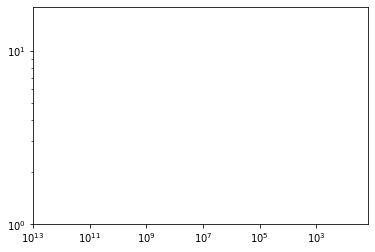

In [209]:
plt.plot(M_500,T_x_fit_TM,'o')
plt.plot(M_500, Tobs,'.')
plt.loglog()
plt.xlim(1e13,1.5e1)
plt.ylim(1e0,18)



# Luminosity Mass Redshift scaling relation

# $L_x = \left( A_{\text{Tx}} + 1e44 \cdot \left[ B_{\text{Tx}} + c_{\text{Tx}} \cdot \frac{1+z}{1+z_{\text{piv}}} \right] \right) \cdot \frac{M_{500}}{M_{\text{piv}}} + B \cdot \frac{E_z}{E_{z_{\text{piv}}}} + y_{\text{Lx}} \cdot( \frac{1+z}{1+z_{\text{piv}}})$


In [210]:

def TM(Obs, A_Tx,B_Tx, c_Tx,  y_Tx):
    """paper : https://arxiv.org/abs/2107.05652 
    """
    return np.exp((ln(A_Tx) + (B_Tx + c_Tx * ln(1+z/1+z_piv)) * ln(M_500/M_piv) + 2/3 * ln(E_z/E_z_piv) + y_Tx * ln(1+z/1+z_piv)) )   

p0 = [3.41, 0.65, -0.02,-1.03]  # Initial guess for parameters

# Perform the fitting process
popt,pcov=curve_fit(TM, (M_500,z),Tobs, p0=p0) 

#  get the best-fit parameters
Ax_fit, Bx_fit, cx_fit,yx_fit = popt
# Evaluate the fit
T_x_fit_TM = TM(Obs, Ax_fit, Bx_fit, cx_fit,yx_fit)

Ax_fit, Bx_fit, cx_fit,yx_fit

(3.594607693157528, 2.9675627097114408, -8.679680991220142, 1.9894373931619087)

In [211]:
Obs

(array([1.06878012e+15, 1.89125825e+15, 1.31374892e+15, 1.69432357e+15,
        1.78222543e+15, 1.53607715e+15, 1.47585851e+15]),
 array([0.22579845, 0.25255689, 0.17362493, 0.54474091, 0.23189752,
        0.27671194, 0.18275993]))

In [212]:
def Lx_M500_z(Obs,A_Lx,B_Lx,c_Lx,y_Lx):
    """
    paper : https://arxiv.org/abs/2107.05652 
    """
    return np.exp(ln(A_Lx) + ln(1e44)+((B_Lx) + c_Lx* ln(1+z/1+z_piv))* ln(M_500/M_piv) *2 * ln(E_z/E_z_piv) + y_Lx * ln(1+z/1+z_piv)    )

p0 = [3.36, 1.44, -0.07,-0.51]  # Initial guess for parameters

# Perform the fitting process
popt1,pcov1=curve_fit(Lx_M500_z, (M_500,z),Lx, p0=p0) 

#  get the best-fit parameters
A_Lx_fit, B_Lx_fit, c_Lx_fit,y_Lx_fit = popt1
# Evaluate the fit
L_x_fit = Lx_M500_z(Obs,A_Lx_fit, B_Lx_fit, c_Lx_fit,y_Lx_fit)

A_Lx_fit, B_Lx_fit, c_Lx_fit,y_Lx_fit

(0.01899225076852756, 231.6944125161894, -508.4911643558727, 17.00192903614348)

In [213]:
# Define the log-likelihood function
def log_likelihood(params, M500, z, Lx):
    A_Lx,B_Lx,c_Lx,y_Lx= params
    Lx_predicted = np.exp(ln(A_Lx) + ln(1e44)+((B_Lx) + c_Lx* ln(1+z/1+z_piv))* ln(M_500/M_piv) *2 * ln(E_z/E_z_piv) + y_Lx * ln(1+z/1+z_piv)    )
    residuals = Lx - Lx_predicted
    sigmas = np.std(residuals)  # Estimate the standard deviation of the residuals
    log_likelihood = -0.5 * np.sum((residuals / sigmas)**2 + np.log(2 * np.pi * sigmas**2))
    return log_likelihood


# Set initial guesses for the parameter values
initial_params = [3.36, 1.44, -0.07,-0.51]   # example initial parameter values

# Define the negative log-likelihood function (to be minimized)
def negative_log_likelihood(params):
    return -log_likelihood(params, M_500, z, Lx)

# Perform maximum likelihood estimation
results = minimize(negative_log_likelihood, initial_params)

# Retrieve the optimized parameter values
optimized_params = results.x
print("Optimized parameter values:", optimized_params)


Optimized parameter values: [ 1.90786962e-02  2.31530240e+02 -5.08118641e+02  1.69911678e+01]


Text(0.5, 0, 'Mass of the cluster  [M_500]')

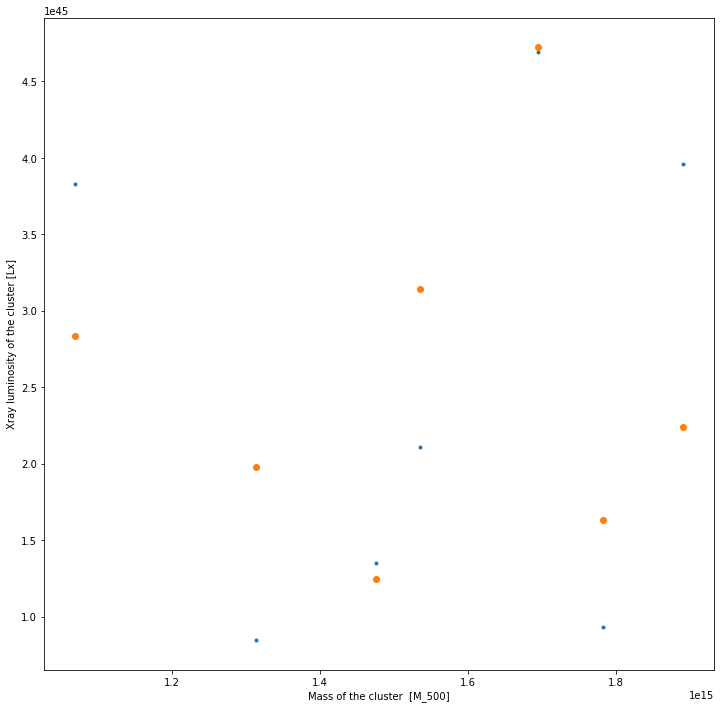

In [214]:
plt.figure(figsize=(12,12))
plt.plot(M_500, Lx,'.')
plt.plot(M_500, L_x_fit,'o')
plt.ylabel('Xray luminosity of the cluster [Lx]')
plt.xlabel('Mass of the cluster  [M_500]')

# Mass concentration scaling relation

array([4.73942122, 4.92356243, 4.82405494, 4.96252077, 4.89748836,
       4.82191362, 4.84772939])

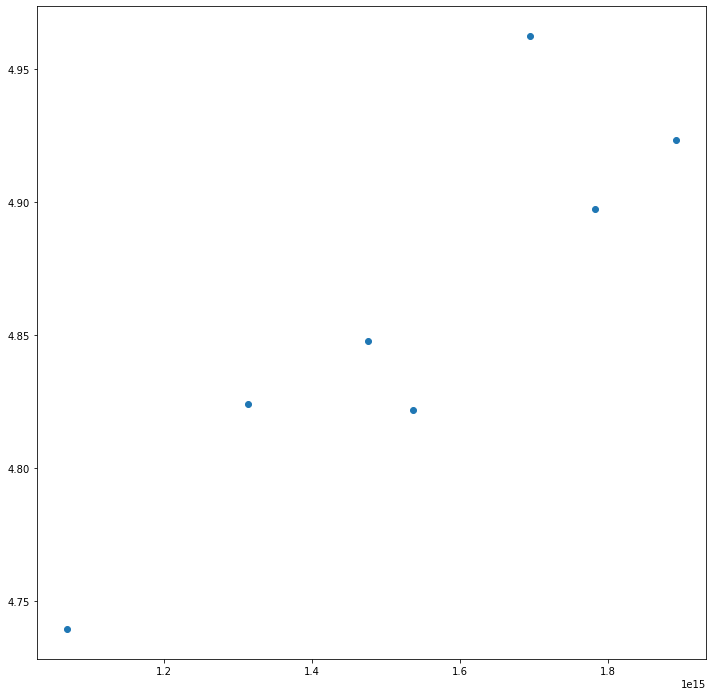

In [215]:
import numpy as np
import  colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration

# Set the cosmology
cosmo = cosmology.setCosmology('planck18')

mass=mm*1e15
# Calculate concentrations for each mass-redshift pair
c = np.array([concentration.concentration(mass, 'vir', red, model='diemer19') for mass,red in zip(mass, red)])
plt.figure(figsize=(12,12))
plt.plot(mass,c,'o')
c


# Richness Mass- redshift scaling  relation

# $\lambda = \exp(A_{\lambda}) + \left[ B_{\lambda} + \sigma_{\lambda} \left ( \frac{1+z}{1+z_{\text{piv}}} \right) \right] \cdot \frac{M_{500}}{M_{\text{piv}}} + \gamma_{\lambda} \left ( \frac{1+z}{1+z_{\text{piv}}} \right)$

In [216]:
rich=np.array([  72,114.096 ,58,46.900, 71.65 ,41.90,71.5])


In [217]:
# richness mass z scaling relation 
def richness_mass_z(Obs,A_lambda,B_lambda,sigma_lambda,gamma_lambda):
    return np.exp(ln(A_lambda)  + (B_lambda+(sigma_lambda)* ln(1+z/1+z_piv))* ln(M_500/M_piv) +gamma_lambda* ln(1+z/1+z_piv)
)

p0 = [36.2, 0.881, -0.56,-0.46]  # Initial guess for parameters

# Perform the fitting process
popt1,pcov1=curve_fit(richness_mass_z, (M_500,z),rich, p0=p0) 

#  get the best-fit parameters
A_lambda_fit,B_lambda_fit,sigma_lambda_fit,gamma_lambda_fit = popt1
# Evaluate the fit
rich_fit = richness_mass_z(Obs,A_lambda_fit,B_lambda_fit,sigma_lambda_fit,gamma_lambda_fit)

A_lambda_fit,B_lambda_fit,sigma_lambda_fit,gamma_lambda_fit

(290.70850439918905,
 -3.4128115749268004,
 11.550493109311638,
 -3.5499801950852845)

In [28]:
rich_fit,rich

(array([44.7064388 , 88.76562281, 69.66832689, 49.95643726, 83.50168756,
        62.24776131, 74.79980162]),
 array([ 72.   , 114.096,  58.   ,  46.9  ,  71.65 ,  41.9  ,  71.5  ]))

In [29]:
# richness mass z scaling relation 
def richness_mass_z(M_500,z,A_lambda,B_lambda,sigma_lambda,gamma_lambda):
    return np.exp(ln(A_lambda)  + (B_lambda+(sigma_lambda)* ln(1+z/1+z_piv))* ln(M_500/M_piv) +gamma_lambda* ln(1+z/1+z_piv)
)

# Define the log-likelihood function
def log_likelihood(params, M500, z, rich):
    
    A_lambda,B_lambda,sigma_lambda,gamma_lambda= params
    rich_predicted = np.exp(ln(A_lambda)  + (B_lambda+(sigma_lambda)* ln(1+z/1+z_piv))* ln(M_500/M_piv) +gamma_lambda* ln(1+z/1+z_piv))
    residuals= rich - rich_predicted
    sig = np.std(residuals)  # Estimate the standard deviation of the residuals
    log_likelihood = -0.5 * np.sum((residuals / sig)**2 + np.log(2 * np.pi * sig**2))
    return log_likelihood

# Set initial guesses for the parameter values
initial_params = [36.2, 0.881, -0.56,-0.46]   # example initial parameter values

# Define the negative log-likelihood function (to be minimized)
def negative_log_likelihood(params):
    return -log_likelihood(params, M_500, z,rich)

# Perform maximum likelihood estimation
resul = minimize(negative_log_likelihood, initial_params)

# Retrieve the optimized parameter values
optimized_params = resul.x
print("Optimized parameter values:", optimized_params)



Optimized parameter values: [290.68834528  -3.41245387  11.54965006  -3.54980592]


In [30]:
resul

      fun: 29.891540617544138
 hess_inv: array([[ 1.05285496,  1.21077403, -1.32937368, -0.0787193 ],
       [ 1.21077403,  1.42038   , -1.57455883, -0.1108555 ],
       [-1.32937368, -1.57455883,  1.76259219,  0.11431517],
       [-0.0787193 , -0.1108555 ,  0.11431517,  0.05735236]])
      jac: array([-4.76837158e-07,  3.09944153e-06,  2.38418579e-06,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 390
      nit: 50
     njev: 78
   status: 0
  success: True
        x: array([290.68834528,  -3.41245387,  11.54965006,  -3.54980592])

In [32]:
Om0=0.307115
Ode0=0.692885

#  mass - velocity dispersion relation

In [33]:
h = 0.7
Omega_L = 0.7
Omega_M = 1 - Omega_L
Omega_k = 0.


In [34]:
import scipy
from scipy import integrate
def E(z):
    """
    Evolution factor E(z) at a given redshift.
    """
    try:
        return (Omega_M * (1+z)**3 + Omega_k * (1+z)**2 + Omega_L) ** 0.5
    except AttributeError:
        from uncertainties import unumpy
        return unumpy.sqrt(Omega_M * (1+z)**3 + Omega_k * (1+z)**2 + Omega_L)

def H(z, unit='default'):
    """
    Hubble constant at a given redshift.
    The units can be km·s⁻¹·Mpc⁻¹ ('default') or s⁻¹ ('s')
    """
    if unit == 's':
        return 100 * h * E(z) * (units.km / units.Mpc)
    return 100 * h * E(z)

def tH(z, unit='Gyr'):
    """
    Hubble time at a given redshift.
    The units can be 's', 'yr' or 'Gyr' (default unit='Gyr').
    """
    f = lambda t: 1. / ((1. + t) * E(t))
    i = integrate.quad(f, z, scipy.inf)[0]
    if unit == 'Gyr':
        return 1 / H(0, unit='s') * i / units.Gyr
    if unit == 'yr':
        return 1 / H(0, unit='s') * i / units.yr
    if unit == 's':
        return 1 / H(0, unit='s') * i
def tHubble(z, unit='Gyr'):
  """
  See cosmology.tH()
  """
  return tH(z, unit)

def lookback(z, unit='Gyr'):
    """
    Lookback time at a given redshift.
    The units can be 's', 'yr' or 'Gyr' (default units='Gyr').
    """
    f = lambda t: 1. / ((1. + t) * E(t))
    i = integrate.quad(f, 0., z, epsrel=1e-6, epsabs=0)[0]
    if unit == 'Gyr':
        return 1 / H(0, unit='s') * i / units.Gyr
    if unit == 'yr':
        return 1 / H(0, unit='s') * i / units.yr
    if unit == 's':
        return 1 / H(0, unit='s') * i

def dH(z=0, unit='Mpc'):
    """
    Hubble distance at a given redshift.
    The units can be 'cm', 'ly', or 'Mpc' (default units='Mpc').
    """
    if unit == 'Mpc':
        return constants.c / H(z) / units.km
    if unit == 'kpc':
        return constants.c / H(z, unit='s') / units.kpc
    if unit == 'cm':
        return constants.c / H(z, unit='s')
    if unit == 'm':
        return constants.c / H(z, unit='s') / units.m
    if unit == 'ly':
        return constants.c / H(z, unit='s') / units.ly

def dHubble(z=0, unit='Mpc'):
    """
    See cosmology.dH()
    """
    return dH(z, unit)

def dC(z1, unit='Mpc', **kwargs):
    """
    Comoving distance at a given redshift or betwen two redshifts.
    The units can be 'cm', 'ly' or 'Mpc' (default units='Mpc').
    """
    f = lambda t: 1 / E(t)
    i = integrate.romberg(f, 0., z1, **kwargs)
    return i * dH(0, unit)

def dM(z, dist, input_unit='deg', unit='Mpc'):
    """
    Transverse comoving distance at redshift z.

    input_unit can be 'arcsec', 'arcmin', 'deg', or 'rad'
    """
    if type(dist) in (list, tuple):
        dist = scipy.array(dist)
    if input_unit == 'arcsec':
        dist /= 3600.
        input_unit = 'deg'
    if input_unit == 'arcmin':
        dist /= 60
        input_unit = 'deg'
    if input_unit == 'deg':
        dist *= scipy.pi / 180
    if Omega_k == 0:
        return dist * dC(z, unit)
    elif Omega_k > 0:
        return dist * dH / scipy.sqrt(Omega_k) * \
               scipy.sinh(scipy.sqrt(Omega_k) * dC(z, unit) / dH(0, unit))
    else:
        return dist * dH / scipy.sqrt(-Omega_k) * \
               scipy.sin(scipy.sqrt(Omega_k) * dC(z, unit) / dH(0, unit))

def dA(z1, z2=0, unit='Mpc'):
    """
    Returns the angular diameter distance between two redshifts (from zero to
    z1, by default). If z2>0, then z2 should be greater than z1.

    The units can be 'cm', 'ly' or 'Mpc' (default units='Mpc').
    """
    if z2 == 0:
        return dC(z1, unit) / (1 + z1)
    elif Omega_k >= 0:
        pseudo_dist = dC(z2, unit) * \
                         scipy.sqrt(1 + Omega_k * \
                                    (dC(z1, unit) / dH(0, unit)) ** 2)
        pseudo_dist -= dC(z1, unit) * \
                       scipy.sqrt(1 + Omega_k * \
                                  (dC(z2, unit) / dH(0, unit)) ** 2)
        return pseudo_dist / (1 + z2)
    else:
        msg = 'Angular Diameter Distance not implemented for values Omega_k < 0'
        raise ValueError(msg)

def dL(z, unit='Mpc'):
    """
    Luminosity distance at a given redshift.
    The units can be 'cm', 'ly' or 'Mpc' (default units='Mpc').
    """
    return dC(z, unit) * (1 + z)

In [35]:
def E(z):
    """
    Evolution factor E(z) at a given redshift.
    """
    try:
        return (Omega_M * (1+z)**3 + Omega_k * (1+z)**2 + Omega_L) ** 0.5
    except AttributeError:
        from uncertainties import unumpy
        return unumpy.sqrt(Omega_M * (1+z)**3 + Omega_k * (1+z)**2 + Omega_L)

In [218]:
def sigma(s, z, ds=None, dz=None,
          radius='200c', scaling='evrard08', bias=(1,0.),
          zscaling=0, separate_errors=False):
    """
        
        evrard08 : Evrard et al. (2008), DM particles
        lau10 : Lau, Nagai, & Kravtsov (2010), DM particles in hydro-
                simulation with cooling and star formation (no AGN feedback)
        munari13dm : Munari et al. (2013), DM particles in AGN simulation
        munari13sub : Munari et al. (2013), DM subhalos in AGN simulation
        munari13gal : Munari et al. (2013), galaxies in AGN simulation
        munari13 : alias for munari13gal
        saro13 : Saro et al. (2013), SAM galaxies
        
    @ Adapted from https://github.com/cristobal-sifon
    """

    Ez = E(z)
    # best-fit parameters from the scaling
    if scaling == 'saro13':
        def Mdyn(s, z, A, B, C):
            return 1e15 * (s / (A * Ez**C)) ** B
        A = ufloat(939., 0.55)
        B = ufloat(2.91, 0.0021)
        C = ufloat(0.33, 0.0019)
        Msyst = Mdyn(s, z, A, B, C)
        if ds is not None:
            if type(s) == numpy.ndarray:
                s = unumpy.uarray(s, ds)
            else:
                s = ufloat(s, ds)
        if dz is not None:
            if type(z) == numpy.ndarray:
                z = unumpy.uarray(z, dz)
            else:
                z = ufloat(z, dz)
        Mstat = Mdyn(s, z, A.nominal_value,
                     B.nominal_value, C.nominal_value)
        if ds:
            if separate_errors:
                if type(s) == numpy.ndarray:
                    err = (numpy.array([M.std_dev for M in Mstat]),
                           numpy.array([M.std_dev for M in Msyst]))
                else:
                    err = (Mstat.std_dev, Msyst.std_dev)
            else:
                if type(s) == numpy.ndarray:
                    err = numpy.array([numpy.hypot(Mst.std_dev, Msy.std_dev) \
                                       for Mst, Msy in zip(Mstat, Msyst)])
                else:
                    err = numpy.hypot(Mstat.std_dev, Msyst.std_dev)
            if type(s) == numpy.ndarray:
                M = numpy.array([M.nominal_value for M in Msyst])
            else:
                M = Msys.nominal_value
            return M, err
        if type(s) == numpy.ndarray:
            return numpy.array([M.nominal_value for M in Msyst])
        return Msyst.nominal_value
    # slope
    A = {'200c': {'evrard08': (0.3361, 0.0026),
                  'lau10': ((0.2724, 0.0149), # z = 0.0
                            (0.2903, 0.0254), # z = 0.6
                            (0.3232, 0.0153)), # z = 1.0
                  'munari13dm': (0.336, 0.0015),
                  'munari13sub': (0.365, 0.0017),
                  'munari13gal': (0.364, 0.0021)},
         '500c': {'lau10': ((0.2965, 0.0144), # z = 0.0
                            (0.2888, 0.0180), # z = 0.6
                            (0.3134, 0.0108))}} # z = 1.0
    A['200c']['munari13'] = A['200c']['munari13gal']
    # normalization
    So = {'200c': {'evrard08': (1082.9, 4.0),
                   'lau10': ((692., 11.), (674., 11.), (671., 8.)),
                   'munari13dm': (1095., 4.4),
                   'munari13sub': (1199., 5.2),
                   'munari13gal': (1177., 4.2)},
          '500c': {'lau10': ((788., 10.), (762., 9.), (771., 11.))}}
    So['200c']['munari13'] = So['200c']['munari13gal']
    # pivot mass
    Mo = {'evrard08': 1e15, 'lau10': 2e14, 'munari13': 1e15}
    Mo['munari13dm'] = Mo['munari13sub'] = Mo['munari13gal'] = Mo['munari13']
    # now read
    a = A[radius][scaling]
    so = So[radius][scaling]
    mo = Mo[scaling]
    if scaling == 'lau10':
        zval = [0.0, 0.6, 1.0]
        i = zval.index(zscaling)
        a, da = a[i]
        so, dso = so[i]
    else:
        a, da = a
        so, dso = so
    try:
        b, db = bias
    except ValueError:
        b = bias
        db = 0.
    m = mo / (h*Ez) * (b*s/so)**(1/a)
    def err(s, z, dsi, dzi):
        ## statistical:
        # dM/dz
        A = 3 * h * mo / (2*Ez**3) * (s/so)**(1/a) * (1+z)**2
        # dM/ds
        B = mo / (h*Ez) * (s/so) ** (1/a) / (a*s)
        stat = numpy.hypot(A*dzi, B*dsi)
        ## systematic:
        # dM/dso
        C = -mo / (h*Ez) * (s/so)**(1/a) / (a*so)
        # dM/da
        D = -mo / (h*Ez) * (s/so)**(1/a) * numpy.log(s/so) / a**2
        # dM/db
        E = m / (b*a)
        syst = numpy.hypot(C*dso, numpy.hypot(D*da, E*db))
        return numpy.array([stat, syst])

    if ds is not None:
        if dz is None:
            dz = 0
        try:
            stat, syst = err(s, z, ds, dz)
            if separate_errors:
                return m, (stat, syst)
        except TypeError:
            st1, syst = err(s, z, ds[0], dz)
            st2, syst = err(s, z, ds[1], dz)
            if separate_errors:
                return m, (st1, st2, syst)
            else:
                return m, (numpy.hypot(st1, syst), scipy.hypot(st2, syst))
        return m, numpy.hypot(stat, syst)
    else:
        return m
    
sigma(1000,z_cl)/1e15

1.0285217015965085

In [37]:
vv=np.array([1202,842,802,1203,1023,1234,932])

In [38]:
sigma(vv,z)

array([1.74113389e+15, 5.95051102e+14, 5.37066492e+14, 1.45367526e+15,
       1.07409515e+15, 1.83099325e+15, 8.35718788e+14])

# m200 -  r200 relation 

In [39]:
1.23e14

123000000000000.0

In [40]:
# r200 using the mass of cluster
import math

# Define constants
M = 1.23e14 * 1.99e30  # mass of cluster in kg from cant t Caustic method

# critical density of the galaxy cluster as fxn of redshift
rho_c=cosmos.critical_density(red)*1e3
f = 200  # factor by which the critical density is multiplied to define r200

# Calculate r200
r200 = ((3 * M) / (4 * math.pi * rho_c * f))**(1/3)

# Convert r200 to units of kpc
r200_Mpc = ((r200 / 3.086e19)/1000).value

r200_Mpc


array([0.97105559, 0.96150951, 0.98953421, 0.85792857, 0.96888294,
       0.95286759, 0.98631511])